<a href="https://colab.research.google.com/github/nikhithamani/Knowledge-Graph-Approach-for-Restructuring-a-Scientific-Feild/blob/main/Project_Nikhitha.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**A Knowledge graph Approach to structure Scientific field**

Step1 : Import Library files

In [3]:
from google.colab import drive
drive.mount('/content/gdrive')

import pandas as pd

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


Step 2 : Sentence Segmentation

In [4]:
filepath = '/content/gdrive/MyDrive/project/X.txt'
with open(filepath,'r') as f:
  content = f.read().split(".")
  df = pd.DataFrame()
  df['sentences'] = content
  # Converting to excel
  df.to_excel('/content/gdrive/MyDrive/project/processed.xlsx', index = False)

Step 3 : Entities Extraction using spacy library

In [5]:
import spacy
nlp = spacy.load('en_core_web_sm')

doc = nlp("Phytoplasmas are insect vectored bacteria that cause disease in a wide range of plant species")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Phytoplasmas ... nsubj
are ... ROOT
insect ... nmod
vectored ... amod
bacteria ... attr
that ... nsubj
cause ... relcl
disease ... dobj
in ... prep
a ... det
wide ... amod
range ... pobj
of ... prep
plant ... compound
species ... pobj


Step 4 : Extract Relations

In [6]:
doc = nlp("Nagal won the first set")

for tok in doc:
  print(tok.text, "...", tok.dep_)

Nagal ... nsubj
won ... ROOT
the ... det
first ... amod
set ... dobj


Step 5: Knowledge Graph Creation

Import Libraries

In [7]:
import re
import pandas as pd
import bs4
import requests
import spacy
from spacy import displacy
nlp = spacy.load('en_core_web_sm')

from spacy.matcher import Matcher 
from spacy.tokens import Span 

import networkx as nx

import matplotlib.pyplot as plt
from tqdm import tqdm

pd.set_option('display.max_colwidth', 200)
%matplotlib inline

Read Data

In [8]:
graph = pd.read_excel('/content/gdrive/MyDrive/project/processed.xlsx')
graph.shape

(63834, 1)

In [9]:
graph['sentences'].sample(5)

37964                                                                                                                                         9%) for indications nonadherent to the guideline were discontinued
60473    Conclusions: The results show that the translation of YP-CORE into Finnish has been successful, the YP-CORE has good psychometric properties, and the measure could be taken into wider use in clini...
11116     Extensive research indicates that Wnt/beta-catenin signaling pathway, which plays a pivotal role in growth, development, and differentiation of hepatocellular carcinoma, is one of the major signa...
12090     Liquid biopsies in the form of circulating tumor DNA and circulating tumor cells allow noninvasive longitudinal monitoring of the molecular landscape of an advanced tumor as it is being treated w...
48608                                                                                                        Reprogrammed H376 (Rep-H376) did not show ESCs morpholo

Entity Pairs Extraction

In [10]:
def get_entities(sent):
  ## chunk 1
  ent1 = ""
  ent2 = ""

  prv_tok_dep = ""    # dependency tag of previous token in the sentence
  prv_tok_text = ""   # previous token in the sentence

  prefix = ""
  modifier = ""

  #############################################################
  
  for tok in nlp(sent):
    ## chunk 2
    # if token is a punctuation mark then move on to the next token
    if tok.dep_ != "punct":
      # check: token is a compound word or not
      if tok.dep_ == "compound":
        prefix = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          prefix = prv_tok_text + " "+ tok.text
      
      # check: token is a modifier or not
      if tok.dep_.endswith("mod") == True:
        modifier = tok.text
        # if the previous word was also a 'compound' then add the current word to it
        if prv_tok_dep == "compound":
          modifier = prv_tok_text + " "+ tok.text
      
      ## chunk 3
      if tok.dep_.find("subj") == True:
        ent1 = modifier +" "+ prefix + " "+ tok.text
        prefix = ""
        modifier = ""
        prv_tok_dep = ""
        prv_tok_text = ""      

      ## chunk 4
      if tok.dep_.find("obj") == True:
        ent2 = modifier +" "+ prefix +" "+ tok.text
        
      ## chunk 5  
      # update variables
      prv_tok_dep = tok.dep_
      prv_tok_text = tok.text
  #############################################################

  return [ent1.strip(), ent2.strip()]

In [11]:
entity_pairs = []

for i in tqdm(graph["sentences"]):
  entity_pairs.append(get_entities(i))

100%|██████████| 63834/63834 [10:53<00:00, 97.61it/s] 


In [12]:
entity_pairs[20:30]

[['', ''],
 ['coli  strains', 'large -)-alpha scale'],
 ['universal  feature', 'intracellular strand RNA membranes'],
 ['CIRV ringspot replication', 'mitochondrial outer membrane'],
 ['product', 'plant mitochondrial cells'],
 ['Here yeast Saccharomyces cerevisiae', 'CIRV cell survival'],
 ['p36', 'cell growth rate'],
 ['p36', 'phosphatidylserine cell externalization'],
 ['tight  association', 'CIRV acid yeast'],
 ['work', 'molecular RNA viruses']]

Relation / Predicate Extraction

In [13]:
def get_relation(sent):

  doc = nlp(sent)

  # Matcher class object 
  matcher = Matcher(nlp.vocab)

  #define the pattern 
  pattern = [{'DEP':'ROOT'}, 
            {'DEP':'prep','OP':"?"},
            {'DEP':'agent','OP':"?"},  
            {'POS':'ADJ','OP':"?"}] 

  matcher.add("matching_1", None, pattern) 

  matches = matcher(doc)
  k = len(matches) - 1

  span = doc[matches[k][1]:matches[k][2]] 

  return(span.text)

In [14]:
relations = [get_relation(i) for i in tqdm(graph['sentences'])]

100%|██████████| 63834/63834 [10:41<00:00, 99.44it/s]


In [ ]:
pd.Series(relations).value_counts()[:50]

Build a Knowledge Graph

In [19]:

# extract subject
source = [i[0] for i in entity_pairs[20:30]]

# extract object
target = [i[1] for i in entity_pairs[20:30]]


kg_df = pd.DataFrame({'source':source, 'target':target, 'edge':relations[20:30]})

In [20]:
# create a directed-graph from a dataframe
G=nx.from_pandas_edgelist(kg_df, "source", "target", 
                          edge_attr=True, create_using=nx.MultiDiGraph())

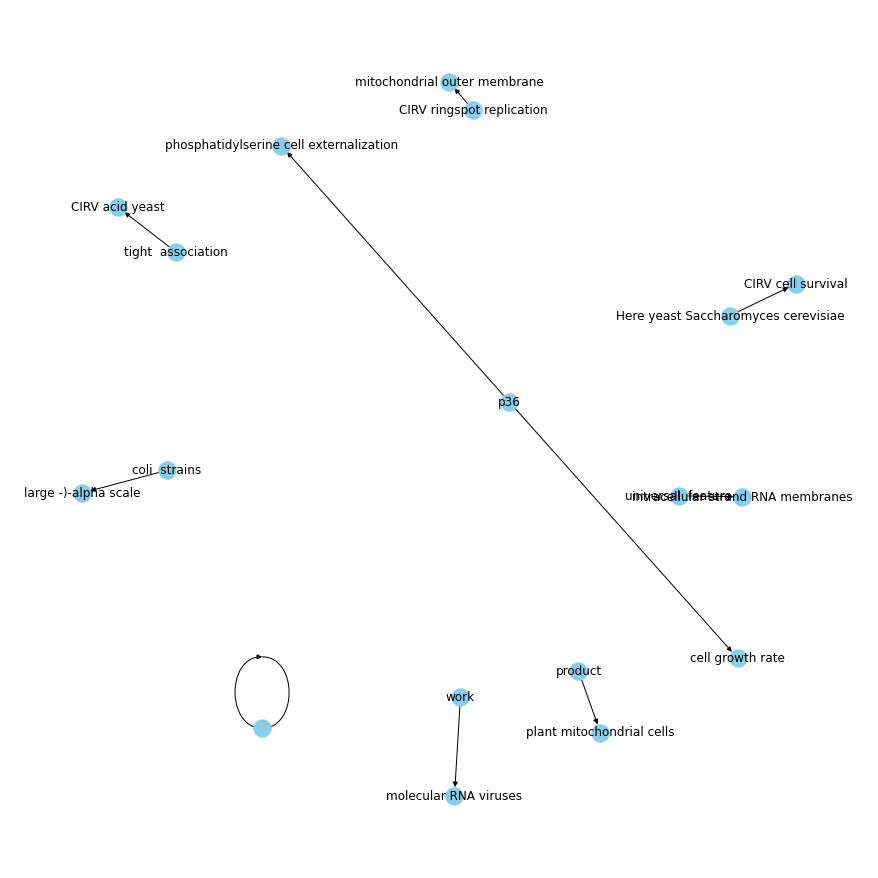

In [21]:
plt.figure(figsize=(12,12))

pos = nx.spring_layout(G)
nx.draw(G, with_labels=True, node_color='skyblue', edge_cmap=plt.cm.Blues, pos = pos)
plt.show()